## fit the power-law distribution with exponential cutoff

We try to fit the following form
$$
y_{\rm model} = \frac{dN}{d\log_{10}x}= 10^A x^{-\beta}\exp (-x/x_c)
$$

$A$, $\beta$, $x_c$ all have uncertainties

The Poisson's log-likelihood function is
$$
\ln L = \sum_i -y_{\rm model} - \ln(y_i!) + y_i\ln y_{\rm model}
$$

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import factorial, gammaln
from scipy.integrate import quad
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def powerlaw_expcutoff(p, logx):
    A = p[0]
    beta = p[1]
    logxc = p[2]
    
    x = 10**logx
    xc = 10**logxc
    return 10**A * x**(-beta) * np.exp(-x/xc)

def get_A(beta, logxc, logxmin, size, dlogx):
    func = lambda logx: powerlaw_expcutoff([0, beta, logxc], logx)
    return np.log10(size*dlogx / quad(func, logxmin, 100)[0]) # 100 is large enough

def neg_log_poisson_likelihood(p, logx, y):
    ymodel = powerlaw_expcutoff(p, logx)
    return -np.sum(-ymodel-gammaln(y+1)+np.log(ymodel)*y)

In [3]:
# generate test data

def sample_powerlaw_expcutoff(rng, logxmin=2, beta=2, logxc=3, size=10000):
    # ChatGPT made this. I don't know if it's correct
    xc = 10**logxc
    samples = []
    while len(samples) < size:
        x = 10**logxmin * (1 - rng.random()) ** (-1 / (beta - 1))

        accept_prob = np.exp(-x / 10**logxc)

        if rng.random() < accept_prob:
            samples.append(x)

    return np.array(samples)


rng = np.random.default_rng(0)

size = 1000
logxmin = 2
logxmax = 5
beta_true = 1 # beta here is the slope of dN/dlogx, not dN/dx
logxc_true = 4

data = sample_powerlaw_expcutoff(rng, logxmin=logxmin, beta=beta_true+1, logxc=logxc_true, size=size)

In [4]:
# fit the parameters

dlogx = 0.025
bins = np.arange(logxmin, logxmax, dlogx)
logx = 0.5 * (bins[1:] + bins[:-1])
y = np.histogram(np.log10(data), bins=bins)[0]

A_true = get_A(beta_true, logxc_true, logxmin=logxmin, size=size, dlogx=dlogx)

bnds = ((None, None), (None, None), (None, None))
guess = [4,1,4]

o = minimize(neg_log_poisson_likelihood, guess, args=(logx,y), bounds=bnds)
A, beta, logxc = o.x

print('A_true = %.2f, A = %.2f'%(A_true, A))
print('beta_true = %.2f, beta = %.2f'%(beta_true, beta))
print('logxc_true = %.2f, logxc = %.2f'%(logxc_true, logxc))

A_true = 3.78, A = 3.74
beta_true = 1.00, beta = 0.99
logxc_true = 4.00, logxc = 4.08


In [5]:
# get uncertainties with bootstrap

nboot = 300
data_boot = data[rng.integers(0, size, (nboot, size))]

A_arr = np.zeros(nboot)
beta_arr = np.zeros(nboot)
logxc_arr = np.zeros(nboot)

for i, d in enumerate(data_boot):
    yboot = np.histogram(np.log10(d), bins=bins)[0]
    o = minimize(neg_log_poisson_likelihood, guess, args=(logx,yboot), bounds=bnds)
    A_arr[i] = o.x[0]
    beta_arr[i] = o.x[1]
    logxc_arr[i] = o.x[2]

print('A_true = %.2f, A = %.2f +- %.2f'%(A_true, np.mean(A_arr), np.std(A_arr)))
print('beta_true = %.2f, beta = %.2f +- %.2f'%(beta_true, np.mean(beta_arr), np.std(beta_arr)))
print('logxc_true = %.2f, logxc = %.2f +- %.2f'%(logxc_true, np.mean(logxc_arr), np.std(logxc_arr)))

A_true = 3.78, A = 3.74 +- 0.11
beta_true = 1.00, beta = 0.98 +- 0.05
logxc_true = 4.00, logxc = 4.09 +- 0.20


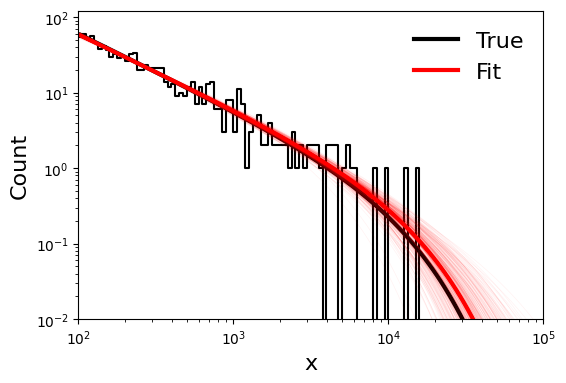

In [6]:
fig, ax0 = plt.subplots(1, 1, figsize=(6,4), sharex=True, sharey=True)

ax0.step(10**logx, y, c='k', where='mid')
ax0.plot(10**logx, powerlaw_expcutoff([A_true, beta_true, logxc_true], logx), c='k', lw=3, label='True')
ax0.plot(10**logx, powerlaw_expcutoff([A, beta, logxc], logx), c='r', lw=3, label='Fit')

for A_boot, beta_boot, logxc_boot in zip(A_arr, beta_arr, logxc_arr):
    ax0.plot(10**logx, powerlaw_expcutoff([A_boot, beta_boot, logxc_boot], logx), c='r', alpha=0.05, lw=0.5)

ax0.legend(frameon=False, fontsize=16, loc='upper right')

ax0.set_xlabel('x', fontsize=16)
ax0.set_ylabel('Count', fontsize=16)
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlim(10**logxmin,10**logxmax)
ax0.set_ylim(1e-2,2*np.max(y))

plt.show()

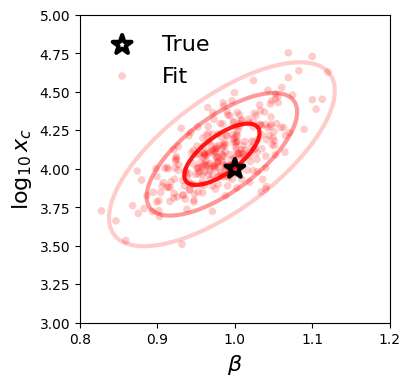

In [7]:
# visualization of parameger uncertainties

def confidence_ellipse(ax, x, y, n_std=3.0, facecolor='none', **kwargs):
    
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)
    
fig, ax0 = plt.subplots(1, 1, figsize=(4,4), sharex=True, sharey=True)

ax0.scatter(beta_true, logxc_true, ec='k', fc='none', lw=3, s=200, alpha=1, marker='*', label='True', zorder=100)

ax0.scatter(beta_arr, logxc_arr, fc='r', ec='none', s=30, alpha=0.2, label='Fit')
confidence_ellipse(ax0, beta_arr, logxc_arr, 1, ec='r', lw=3, alpha=0.9)
confidence_ellipse(ax0, beta_arr, logxc_arr, 2, ec='r', lw=3, alpha=0.4)
confidence_ellipse(ax0, beta_arr, logxc_arr, 3, ec='r', lw=3, alpha=0.2)

ax0.legend(frameon=False, fontsize=16, loc='upper left')

ax0.set_xlabel(r'$\beta$', fontsize=16)
ax0.set_ylabel(r'$\log_{10} x_c$', fontsize=16)
ax0.set_xlim(beta_true-0.2, beta_true+0.2)
ax0.set_ylim(logxc_true-1, logxc_true+1)

plt.show()